In [1]:
import pandas as pd

bench = 'nb301'
suffix = '_full' if bench != 'nb101' and 'macro' not in bench else '_first'
cfg = f'../zc_combine/configs/{bench}{suffix}.json'
dataset = 'cifar10'

In [2]:
from zc_combine.utils.script_utils import create_cache_filename
from zc_combine.utils.script_utils import load_feature_proxy_dataset

version_key = 'paper'
cache_path = create_cache_filename('../scripts/cache_data/', cfg, None, version_key, True)

_, data, y = load_feature_proxy_dataset('../data', bench, dataset, cfg=cfg, use_all_proxies=True,
                                        cache_path=cache_path, version_key=version_key)

In [3]:
from zc_combine.fixes.operations import get_ops_nb301

ops = ['out', *get_ops_nb301()]
ops

['out',
 'max_pool_3x3',
 'avg_pool_3x3',
 'skip_connect',
 'sep_conv_3x3',
 'sep_conv_5x5',
 'dil_conv_3x3',
 'dil_conv_5x5']

In [4]:
data['sep_convs'] = data[[c for c in data.columns if 'op_count' in c and ('_4' in c or '_5' in c)]].sum(axis=1)
data['dil_convs'] = data[[c for c in data.columns if 'op_count' in c and ('_6' in c or '_7' in c)]].sum(axis=1)
data['#convs'] = data['sep_convs'] + data['dil_convs']
data['#convs']

/tmp/ipykernel_27749/1961143760.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['sep_convs'] = data[[c for c in data.columns if 'op_count' in c and ('_4' in c or '_5' in c)]].sum(axis=1)
/tmp/ipykernel_27749/1961143760.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['dil_convs'] = data[[c for c in data.columns if 'op_count' in c and ('_6' in c or '_7' in c)]].sum(axis=1)
/tmp/ipykernel_27749/1961143760.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert

0        10
1        10
2         7
3         7
4         7
         ..
11216    13
11217    12
11218     8
11219     8
11220    10
Name: #convs, Length: 11221, dtype: int64

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

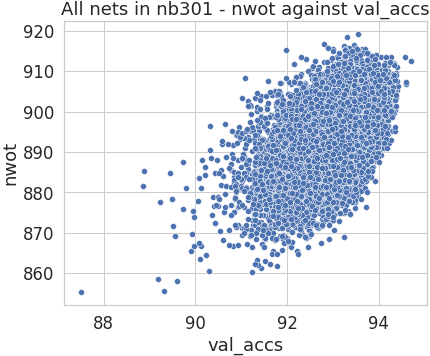

In [32]:
n_palette = len(data['#convs'].unique())

plt.rcParams.update({'text.usetex': False, 'font.family': 'serif', 'text.latex.preamble': '\\usepackage{times} ', 'figure.figsize': (3.25, 2.0086104634371584), 'figure.constrained_layout.use': True, 'figure.autolayout': False, 'savefig.bbox': 'tight', 'savefig.pad_inches': 0.015, 'font.size': 10, 'axes.labelsize': 10, 'legend.fontsize': 6, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'axes.titlesize': 8})
sns.set(font_scale=1.5)# palette=sns.color_palette()[::-1])
sns.set_style('whitegrid')

prox = 'nwot'

plt.figure(figsize=(6,5))

sns.scatterplot(data=data, y='nwot', x=y)
plt.title(f'All nets in {bench} - nwot against val_accs')
plt.savefig(f'{bench}_nwot.pdf')
plt.show()

In [22]:
plt.figure()
sns.scatterplot(data=data[data['nwot'] > 0], y='nwot', x=y, hue=data['n_convs'], palette=sns.color_palette()[:n_palette])
plt.show()

KeyError: 'n_convs'

<Figure size 234x144.62 with 0 Axes>

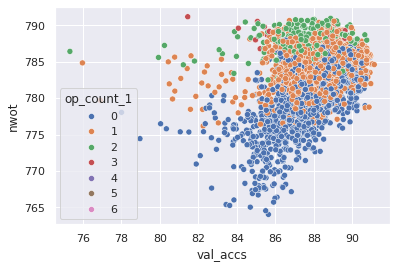

In [44]:
plt.figure()
sns.scatterplot(data=data[(data['nwot'] > 0) & (data['n_convs'] == 3)], y='nwot', x=y, hue=data['op_count_1'], palette=sns.color_palette()[:n_palette])
plt.show()

In [9]:
proxies = [c for c in data.columns if 'op_' not in c and '(' not in c and c not in ['net', '#convs', 'dil_convs', 'sep_convs', 'n_convs']]
print(proxies)

['epe_nas', 'fisher', 'flops', 'grad_norm', 'grasp', 'jacov', 'l2_norm', 'nwot', 'params', 'plain', 'snip', 'synflow', 'zen']


In [37]:
import scipy.stats
import pandas as pd


compute_tau = False
res_corrs = []

def get_corr(d):
    return {k: func(d[k], y[d.index])[0] for k in proxies}


for nc in sorted(data['#convs'].unique()):
    if 3 > nc or nc > 15:
        continue
    
    filtnets = data[data['#convs'] == nc]
    
    func = scipy.stats.kendalltau if compute_tau else scipy.stats.spearmanr
    
    res = get_corr(filtnets)
    res = {'#convs': nc, **res}
    res_corrs.append(res)
    
res_all = get_corr(data)
res_all = {'#convs': 'all', **res_all}
res_corrs.append(res_all)

df = pd.DataFrame(res_corrs)
df.T

,0,1,2,3,4,5,6,7,8,9,10
sep_convs,3,4,5,6,7,8,9,10,11,12,all
epe_nas,0.015839,-0.041156,0.008631,0.057278,-0.006613,0.030395,-0.114601,-0.221826,0.541036,-0.5,0.001997
fisher,-0.493944,-0.495694,-0.476682,-0.491345,-0.49871,-0.509688,-0.573338,-0.551364,-0.212767,-1.0,-0.272209
flops,0.203401,0.162223,0.102711,0.059416,0.076017,-0.023602,-0.118081,-0.073513,-0.182372,-1.0,0.421585
grad_norm,-0.417019,-0.435551,-0.43516,-0.452363,-0.45608,-0.510683,-0.55939,-0.59521,0.182372,-1.0,-0.034796
grasp,0.361756,0.351015,0.364933,0.378202,0.338312,0.355801,0.361944,0.362605,0.607906,0.5,0.340342
jacov,0.078233,0.013432,0.040563,0.025197,0.059453,0.099926,0.175352,0.050573,0.012158,-0.5,-0.058144
l2_norm,0.24078,0.211881,0.151178,0.116744,0.104802,0.01532,-0.080711,-0.006889,-0.279637,-1.0,0.456629
nwot,0.304721,0.261827,0.21523,0.187166,0.176042,0.073129,0.106228,0.023179,-0.285716,-0.5,0.472931
params,0.243946,0.210265,0.145945,0.108882,0.10733,0.011664,-0.093559,0.011631,-0.212767,-1.0,0.458808


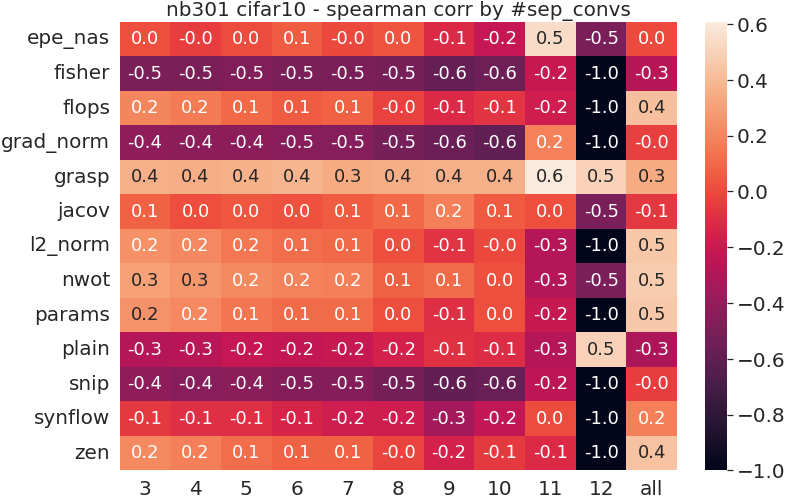

In [38]:
heatdf = df.T
heatdf.rename(columns=heatdf.iloc[0], inplace=True)
heatdf.drop(heatdf.index[0], inplace=True)


plt.rcParams.update({'text.usetex': False, 'font.family': 'serif', 'text.latex.preamble': '\\usepackage{times} ', 'figure.figsize': (3.25, 2.0086104634371584), 'figure.constrained_layout.use': True, 'figure.autolayout': False, 'savefig.bbox': 'tight', 'savefig.pad_inches': 0.015, 'font.size': 18, 'axes.labelsize': 20, 'legend.fontsize': 6, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.titlesize': 20})
#sns.set(font_scale=1.5)# palette=sns.color_palette()[::-1])
sns.set_style('whitegrid')

plt.figure(figsize=(11, 7))
sns.heatmap(data=heatdf.astype(float), annot=True, fmt=".1f")
plt.title(f'{bench} {dataset} - spearman corr by #convs')
#plt.tight_layout()
plt.savefig(f'figs/heat_{bench}.pdf')
plt.show()

In [56]:
func(data['nwot'], data['params'])

SignificanceResult(statistic=0.9532098755757871, pvalue=0.0)

In [50]:
func(data['sep_convs'], y)

SignificanceResult(statistic=0.4591490569157682, pvalue=0.0)

/tmp/ipykernel_27749/1263089440.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=data, y='sep_convs', x=y, palette=sns.color_palette()[:n_palette])


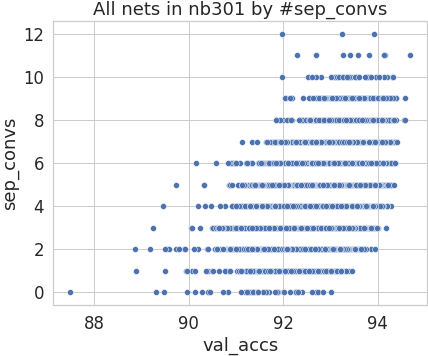

In [36]:
plt.figure(figsize=(6, 5))
sns.scatterplot(data=data, y='sep_convs', x=y, palette=sns.color_palette()[:n_palette])
plt.title(f'All nets in {bench} by #sep_convs')
plt.savefig(f'{bench}_sepconvs.pdf')
plt.show()